In [1]:
import numpy as np
import random
import cv2
from tqdm import tqdm
import os
from sklearn.model_selection import train_test_split

NUM_OF_IMAGES = 12500
IMG_SIZE = 100
BASE_DIR = "./PetImages"

def label_image(type):
    if type == "Dog":
        return np.array([0,1])
    if type == "Cat":
        return np.array([1,0])
    raise Exception("Unknown Type")

def process_image(path):
    try:
        image = cv2.imread(path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        return image
    except Exception as e:
        return None

def process_data(img_nums, type, should_label):
    dataset = []
    base_dir = f'{BASE_DIR}/{type}'
    for num in tqdm(img_nums):
        path = os.path.join(base_dir, f'{num}.jpg')
        image = process_image(path)
        if image is not None:
            if should_label:
                dataset.append([np.array(image), label_image(type)])
            else:
                dataset.append([np.array(image), num])
    random.shuffle(dataset)
    return dataset

# Create image indices, each data set has the same size
indices = np.arange(NUM_OF_IMAGES)
# Split indices for cats to have train & test datasets.
# This test datasets will be used for verification of trained model
train_cats_indices, test_cats_indices = train_test_split(indices, test_size=0.01, random_state=42)
# Split indices for dogs to have train & test datasets.
# This test datasets will be used for verification of trained model
train_dogs_indices, test_dogs_indices = train_test_split(indices, test_size=0.01, random_state=42)

# Process training data
cats_train_data = process_data(train_cats_indices, "Cat", True)
dogs_train_data = process_data(train_dogs_indices, "Dog", True)

# Convert to numpy arrays
cats_train_data = np.asarray(cats_train_data, dtype="object")
dogs_train_data = np.asarray(dogs_train_data, dtype="object")

# Combine and shuffle train data
train_data = np.concatenate((cats_train_data, dogs_train_data), axis=0)
np.random.shuffle(train_data)

# Save train data
np.save('train_data.npy', train_data)

# Process testing data
cats_test_data = process_data(test_cats_indices, "Cat", False)
dogs_test_data = process_data(test_dogs_indices, "Dog", False)

# Convert to numpy arrays
cats_test_data = np.asarray(cats_test_data, dtype="object")
dogs_test_data = np.asarray(dogs_test_data, dtype="object")

# Combine and shuffle train data
test_data = np.concatenate((cats_test_data, dogs_test_data), axis=0)
np.random.shuffle(test_data)

# Save train data
np.save('test_data.npy', test_data)

 72%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                     | 8964/12375 [00:08<00:02, 1155.32it/s]Corrupt JPEG data: 399 extraneous bytes before marker 0xd9
Corrupt JPEG data: 226 extraneous bytes before marker 0xd9
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [00:00<00:00, 1119.14it/s]


In [2]:
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load the preprocessed training data
train_data = np.load('train_data.npy', allow_pickle=True)

# Extract features and labels
X = np.array([i[0] for i in train_data]).reshape(-1, IMG_SIZE, IMG_SIZE, 3)
y = np.array([i[1] for i in train_data])

# Normalize the data
X = X / 255.0

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Create an ImageDataGenerator for data augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train)

# Verify the shape of the training and validation sets
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")

X_train shape: (22226, 100, 100, 3)
y_train shape: (22226, 2)
X_val shape: (2470, 100, 100, 3)
y_val shape: (2470, 2)


In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import Callback

# Define the custom callback for batch metrics
class BatchMetrics(Callback):
    def __init__(self, val_data):
        super(BatchMetrics, self).__init__()
        self.val_data = val_data
    
    def on_epoch_end(self, epoch, logs=None):
        val_data, val_labels = self.val_data
        predictions = self.model.predict(val_data)
        cat_predictions = np.argmax(predictions, axis=1) == 0
        dog_predictions = np.argmax(predictions, axis=1) == 1
        cat_labels = np.argmax(val_labels, axis=1) == 0
        dog_labels = np.argmax(val_labels, axis=1) == 1
        correct_cats = np.sum(cat_predictions & cat_labels)
        correct_dogs = np.sum(dog_predictions & dog_labels)
        print(f"Epoch {epoch+1}: Correct Cats: {correct_cats}, Correct Dogs: {correct_dogs}")

# Define the model
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Create an ImageDataGenerator for data augmentation
# Improve results of training on image datasets
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fit the ImageDataGenerator on the training data
datagen.fit(X_train)

# Initialize the custom callback with validation data
batch_metrics = BatchMetrics(val_data=(X_val, y_val))

# Train the model using the data generator
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    epochs=10,
    validation_data=(X_val, y_val),
    callbacks=[batch_metrics]
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 98, 98, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 49, 49, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 47, 47, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,370,818 (12.86 MB)

 Trainable params: 3,370,818 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10


/opt/homebrew/Cellar/jupyterlab/4.0.9_2/libexec/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/stepep - accu
Epoch 1: Correct Cats: 330, Correct Dogs: 1111
695/695 ━━━━━━━━━━━━━━━━━━━━ 57s 81ms/step - accuracy: 0.5359 - loss: 0.6899 - val_accuracy: 0.5834 - val_loss: 0.6541
Epoch 2/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/stepep - accur
Epoch 2: Correct Cats: 665, Correct Dogs: 1069
695/695 ━━━━━━━━━━━━━━━━━━━━ 57s 82ms/step - accuracy: 0.6319 - loss: 0.6424 - val_accuracy: 0.7020 - val_loss: 0.5703
Epoch 3/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/stepep - accu
Epoch 3: Correct Cats: 697, Correct Dogs: 1085
695/695 ━━━━━━━━━━━━━━━━━━━━ 58s 83ms/step - accuracy: 0.6881 - loss: 0.5867 - val_accuracy: 0.7215 - val_loss: 0.5383
Epoch 4/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/stepep - accu
Epoch 4: Correct Cats: 868, Correct Dogs: 1064
695/695 ━━━━━━━━━━━━━━━━━━━━ 56s 81ms/step - accuracy: 0.7130 - loss: 0.5585 - val_accuracy: 0.7822 - val_loss: 0.4639
Epoch 5/10
78/78 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/stepep - accur
Epoch 5: Correct Cats: 842, Correct Dogs: 110

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
cat: 0.9842056035995483, dog: 0.01579437218606472
Predicted class: cat


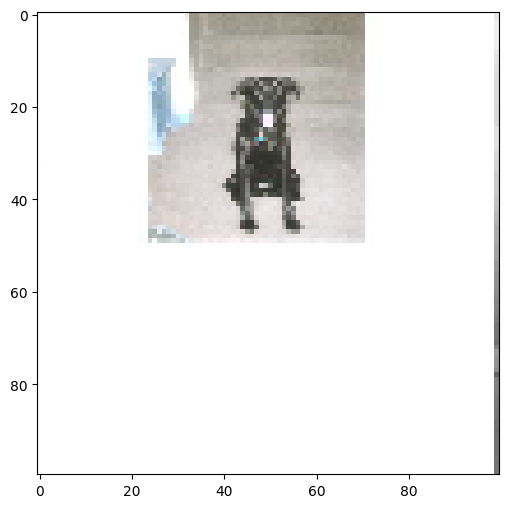

In [4]:
import numpy as np
import matplotlib.pyplot as plt

# Load the test data
test_data = np.load('test_data.npy', allow_pickle=True)

# Select a sample from the test data
d = test_data[2]
img_data, img_num = d

# Reshape and normalize the image data
data = img_data.reshape(1, IMG_SIZE, IMG_SIZE, 3) / 255.0

# Make a prediction
prediction = model.predict(data)[0]

# Display Results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(img_data)

print(f"cat: {prediction[0]}, dog: {prediction[1]}")
predicted_class = "cat" if prediction[0] > prediction[1] else "dog"
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


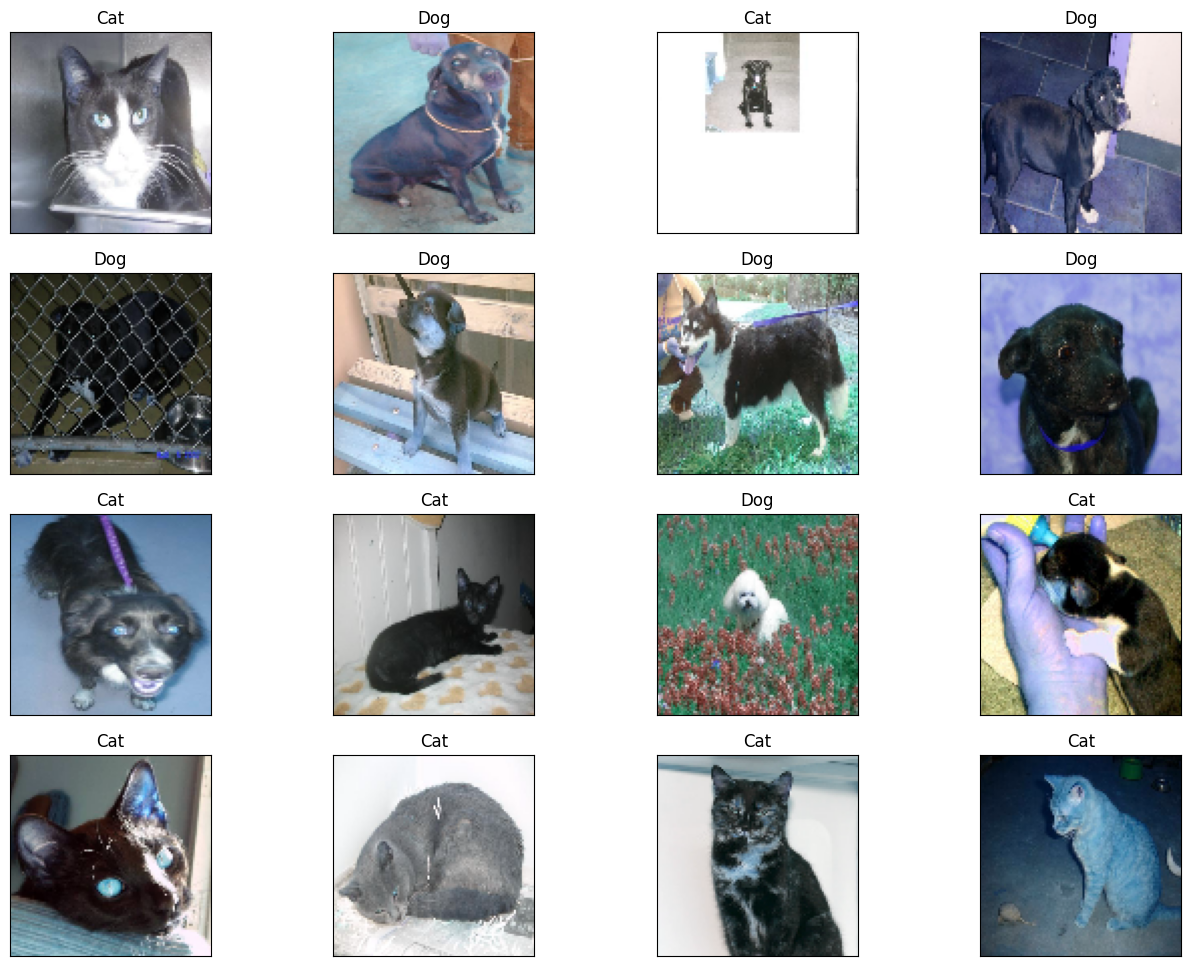

In [5]:
import matplotlib.pyplot as plt

# Load test data
test_data = np.load('test_data.npy', allow_pickle=True)

fig = plt.figure(figsize=(16, 12))

for num, data in enumerate(test_data[:16]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 4, num + 1)
    orig = img_data
    data = img_data.reshape(1, IMG_SIZE, IMG_SIZE, 3) / 255.0  # Add batch dimension and normalize
    model_out = model.predict(data)[0]
    
    if np.argmax(model_out) == 1: 
        str_label = 'Dog'
    else:
        str_label = 'Cat'
        
    y.imshow(orig)
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

plt.show()


2it [00:00, 23.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
cat: 0.7938319444656372, dog: 0.2061680257320404
Predicted class: cat


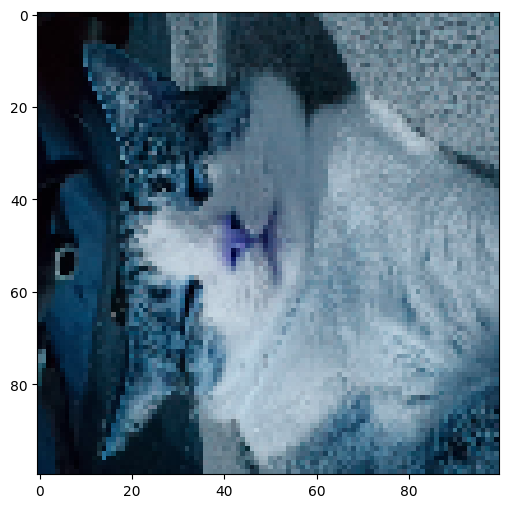

In [6]:
def process_custom_data():
    dataset = []
    base_dir = "moje/"
    moje = ["blancik", "anuszka"]
    for num, kot in tqdm(enumerate(moje)):
        path = os.path.join(base_dir, f'{kot}.jpg')
        image = process_image(path)
        dataset.append([np.array(image), num])
    random.shuffle(dataset)
    return dataset

moje_koty = process_custom_data()
moje_koty = np.asarray(moje_koty, dtype="object")

import numpy as np
import matplotlib.pyplot as plt

# Load the test data

# Select a sample from the test data
d = moje_koty[0]
img_data, img_num = d

# Reshape and normalize the image data
data = img_data.reshape(1, IMG_SIZE, IMG_SIZE, 3) / 255.0

# Make a prediction
prediction = model.predict(data)[0]

# Display Results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(img_data)

print(f"cat: {prediction[0]}, dog: {prediction[1]}")
predicted_class = "cat" if prediction[0] > prediction[1] else "dog"
print(f"Predicted class: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
cat: 0.9546923041343689, dog: 0.04530777409672737
Predicted class: cat


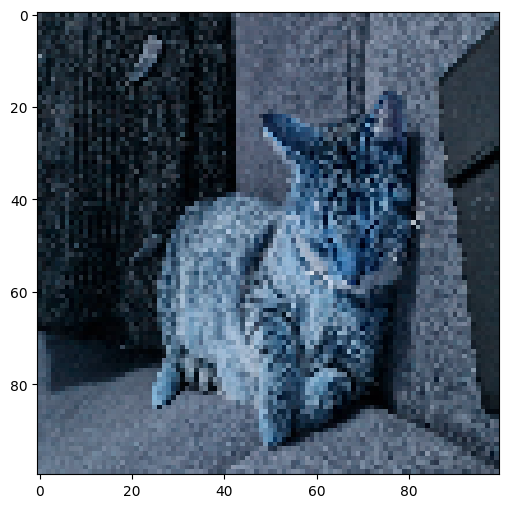

In [7]:
# Select a sample from the test data
d = moje_koty[1]
img_data, img_num = d

# Reshape and normalize the image data
data = img_data.reshape(1, IMG_SIZE, IMG_SIZE, 3) / 255.0

# Make a prediction
prediction = model.predict(data)[0]

# Display Results
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111)
ax.imshow(img_data)

print(f"cat: {prediction[0]}, dog: {prediction[1]}")
predicted_class = "cat" if prediction[0] > prediction[1] else "dog"
print(f"Predicted class: {predicted_class}")